In [98]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
import os
from copy import deepcopy

In [99]:
plt.style.use(['science'])
plt.style.use(['no-latex'])
plt.rcParams['text.usetex'] = False
TOSAVE = True
plt.rcParams.update({'figure.dpi': '600'})

In [100]:
def read_log(path):
    out = dict()
    with open(path, 'r') as f:
        lines = f.read().splitlines()

    args = dict()
    df = pd.DataFrame(columns=['epoch', 'batch', 'time', 'time_0', 'data', 'data_0', 'Xent', 'Xent_0', 'Htri', 'Htri_0', 'Acc', 'Acc_0'])
    results = dict()
    maps = []
    ranks = {
        'Rank-1': [],
        'Rank-5': [],
        'Rank-10': [],
        'Rank-20': [],
    }

    for line in lines:
        if line.startswith('Experiment time'):
            out['time'] = line[16:]
        elif line.startswith('Args'):
            #Args:Namespace
            l = line[15:-1]
            l = l.split(', ')
            i=0
            while i < len(l):
                arg = l[i]
                if arg.startswith('stepsize'):
                    arg += ', ' + l[i+1]
                    k,v = arg.split('=')
                    args[k] = v
                    i+=1
                else:
                    k,v = arg.split('=')
                    args[k] = v
                i+=1
        elif line.startswith('Epoch:'):
            d = []
            ll = line.split('\t')
            for l in ll:
                l = l.split(' ')
                if l==['']:
                    pass
                elif l[0] == 'Epoch:':
                    a = l[1].index(']')
                    d.append(int(l[1][1:a]))
                    d.append(l[1][a+1:])
                else:
                    d.append(float(l[1]))
                    d.append(float(l[2][1:-1]))
            df.loc[len(df)] = d
        elif line.startswith('mAP:'):
            l = line.split(' ')
            maps.append(float(l[1][:-1]))
            results['mAP'] = float(l[1][:-1])
        elif line.startswith('Rank'):
            l = line.split(' ')
            name = l[0]
            results[name] = float(l[-1][:-1])
            ranks[name].append(float(l[-1][:-1]))

    to_p = ''
    for k,v in results.items():
        to_p += str(v) + ' '
    results['print'] = to_p
    results['maps'] = maps
    results['ranks'] = ranks
    out['args'] = args
    out['df'] = df
    out['results'] = results
            
    return out 

In [101]:
def myplot(y, x=None, xlabel='Step', ylabel='Acc', window=1):
    fig, ax = plt.subplots()
    plt.figure(figsize=(20, 10))
    if x is None:
        x = list(range(len(y)))
    x = np.array(x)
    y = np.array(y)

    # sliding average
    x = x[window-1:]
    y = np.convolve(y, np.ones(window), 'valid') / window

    plt.plot(x, y)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = plt.gca()
    plt.text(0.93, 1.05, '$w =$ '+str(window), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=8)
    plt.show()

In [102]:
def read_logs(path, metric='Acc', type='train'):
    paths = os.listdir(path)
    paths = [p for p in paths if not p.startswith('.')]
    new_paths = []
    out2 = []
    for p in paths:
        out2.append(p)
        new_paths.append(os.path.join(path, p))
    new_paths = [n + '/log_train.txt' for n in new_paths]
    if type=='train':
        out = np.zeros(shape=(len(read_log(new_paths[0])['df'][metric]), len(new_paths)))
    else:
        if metric=='mAP':
            out = np.zeros(shape=(len(read_log(new_paths[0])['results']['maps']), len(new_paths)))
        else:
            out = np.zeros(shape=(len(read_log(new_paths[0])['results']['ranks']['Rank-1']), 4,  len(new_paths)))
    for i, p in enumerate(new_paths):
        read = read_log(p)
        if type=='train':
            df = read['df'][metric]
            out[:,i] = df
        elif type=='test':
            if metric=='mAP':
                df = read['results']['maps']
                out[:,i] = df
            elif metric=='rank':
                df = read['results']['ranks']
                out[:,0,i] = df['Rank-1']
                out[:,1,i] = df['Rank-5']
                out[:,2,i] = df['Rank-10']
                out[:,3,i] = df['Rank-20']
    return out, out2

def myplots(data, labels, ylabel='Acc', window=1, ylim=None, name='plot', wdelta=2, type='train', xlabel='Step', size=(5.5, 3.5), remove_one=False):
    if ylabel == 'rank':
        fig, axes = plt.subplots(figsize=size)
    else:
        fig, axes = plt.subplots(figsize=size)
    #plt.figure(figsize=(5.5, 3.5))

    x = list(range(len(data[:,0])))
    x = np.array(x)

    if ylabel != 'rank':
        for i in range(data.shape[1]):
            y = data[:,i]
            y = np.array(y)
            # sliding average

            x_other = x[window-1:]

            y = np.convolve(y, np.ones(window), 'valid') / window

            plt.plot(x_other, y)
    else:
        colors = ['blue', 'green', 'red', 'orange', 'purple']
        type = ['--', '-.', ':', '-']
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                y = data[:,i,j]
                y = np.array(y)
                # sliding average

                x_other = x[window-1:]

                y = np.convolve(y, np.ones(window), 'valid') / window

                plt.plot(x_other, y, color=colors[j], linestyle=type[i])
        dummy_lines = []
        for b_idx in range(4):
            dummy_lines.append(axes.plot([],[], c="black", ls = type[b_idx])[0])
        if remove_one:
            ll = [1,2,3]
            ll2 = ["Rank-5", "Rank-10", "Rank-20"]
        else:
            ll = [0,1,2,3]
            ll2 = ["Rank-1", "Rank-5", "Rank-10", "Rank-20"]
        legend2 = plt.legend([dummy_lines[i] for i in ll], ll2, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=4)
        axes.add_artist(legend2)
        # redefine size of the plot so that we can see that last legend
        box = axes.get_position()
        axes.set_position([box.x0, box.y0 + box.height * 0.2,
                        box.width, box.height*0.9])


    plt.xlabel(xlabel)
    ylabel = ylabel + ' (w = ' + str(window) + ')'
    plt.ylabel(ylabel)
    plt.legend(labels, fontsize=8)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlim([window-1, len(x)-1])

    if type=='train':
        for i in range(1, 10):
            # write "Epoch" every 59 steps
            plt.axvline(i*59, color='black', linestyle='--', alpha=0.1)
            plt.text(i*59+window, ylim[1]+wdelta, 'Epoch '+str(i+1), horizontalalignment='center', verticalalignment='center', fontsize=7, alpha=0.4)

    #plt.text(0.93, 1.05, '$w =$ '+str(window), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=8)
    plt.savefig(f'plots/{name}.png')
    plt.show()

['mobilenet_v3_small-veri', 'vit_b_16-veri', 'resnet34-veri', 'resnet34_fc512-veri', 'resnet50_fc512-veri', 'resnet50-veri']


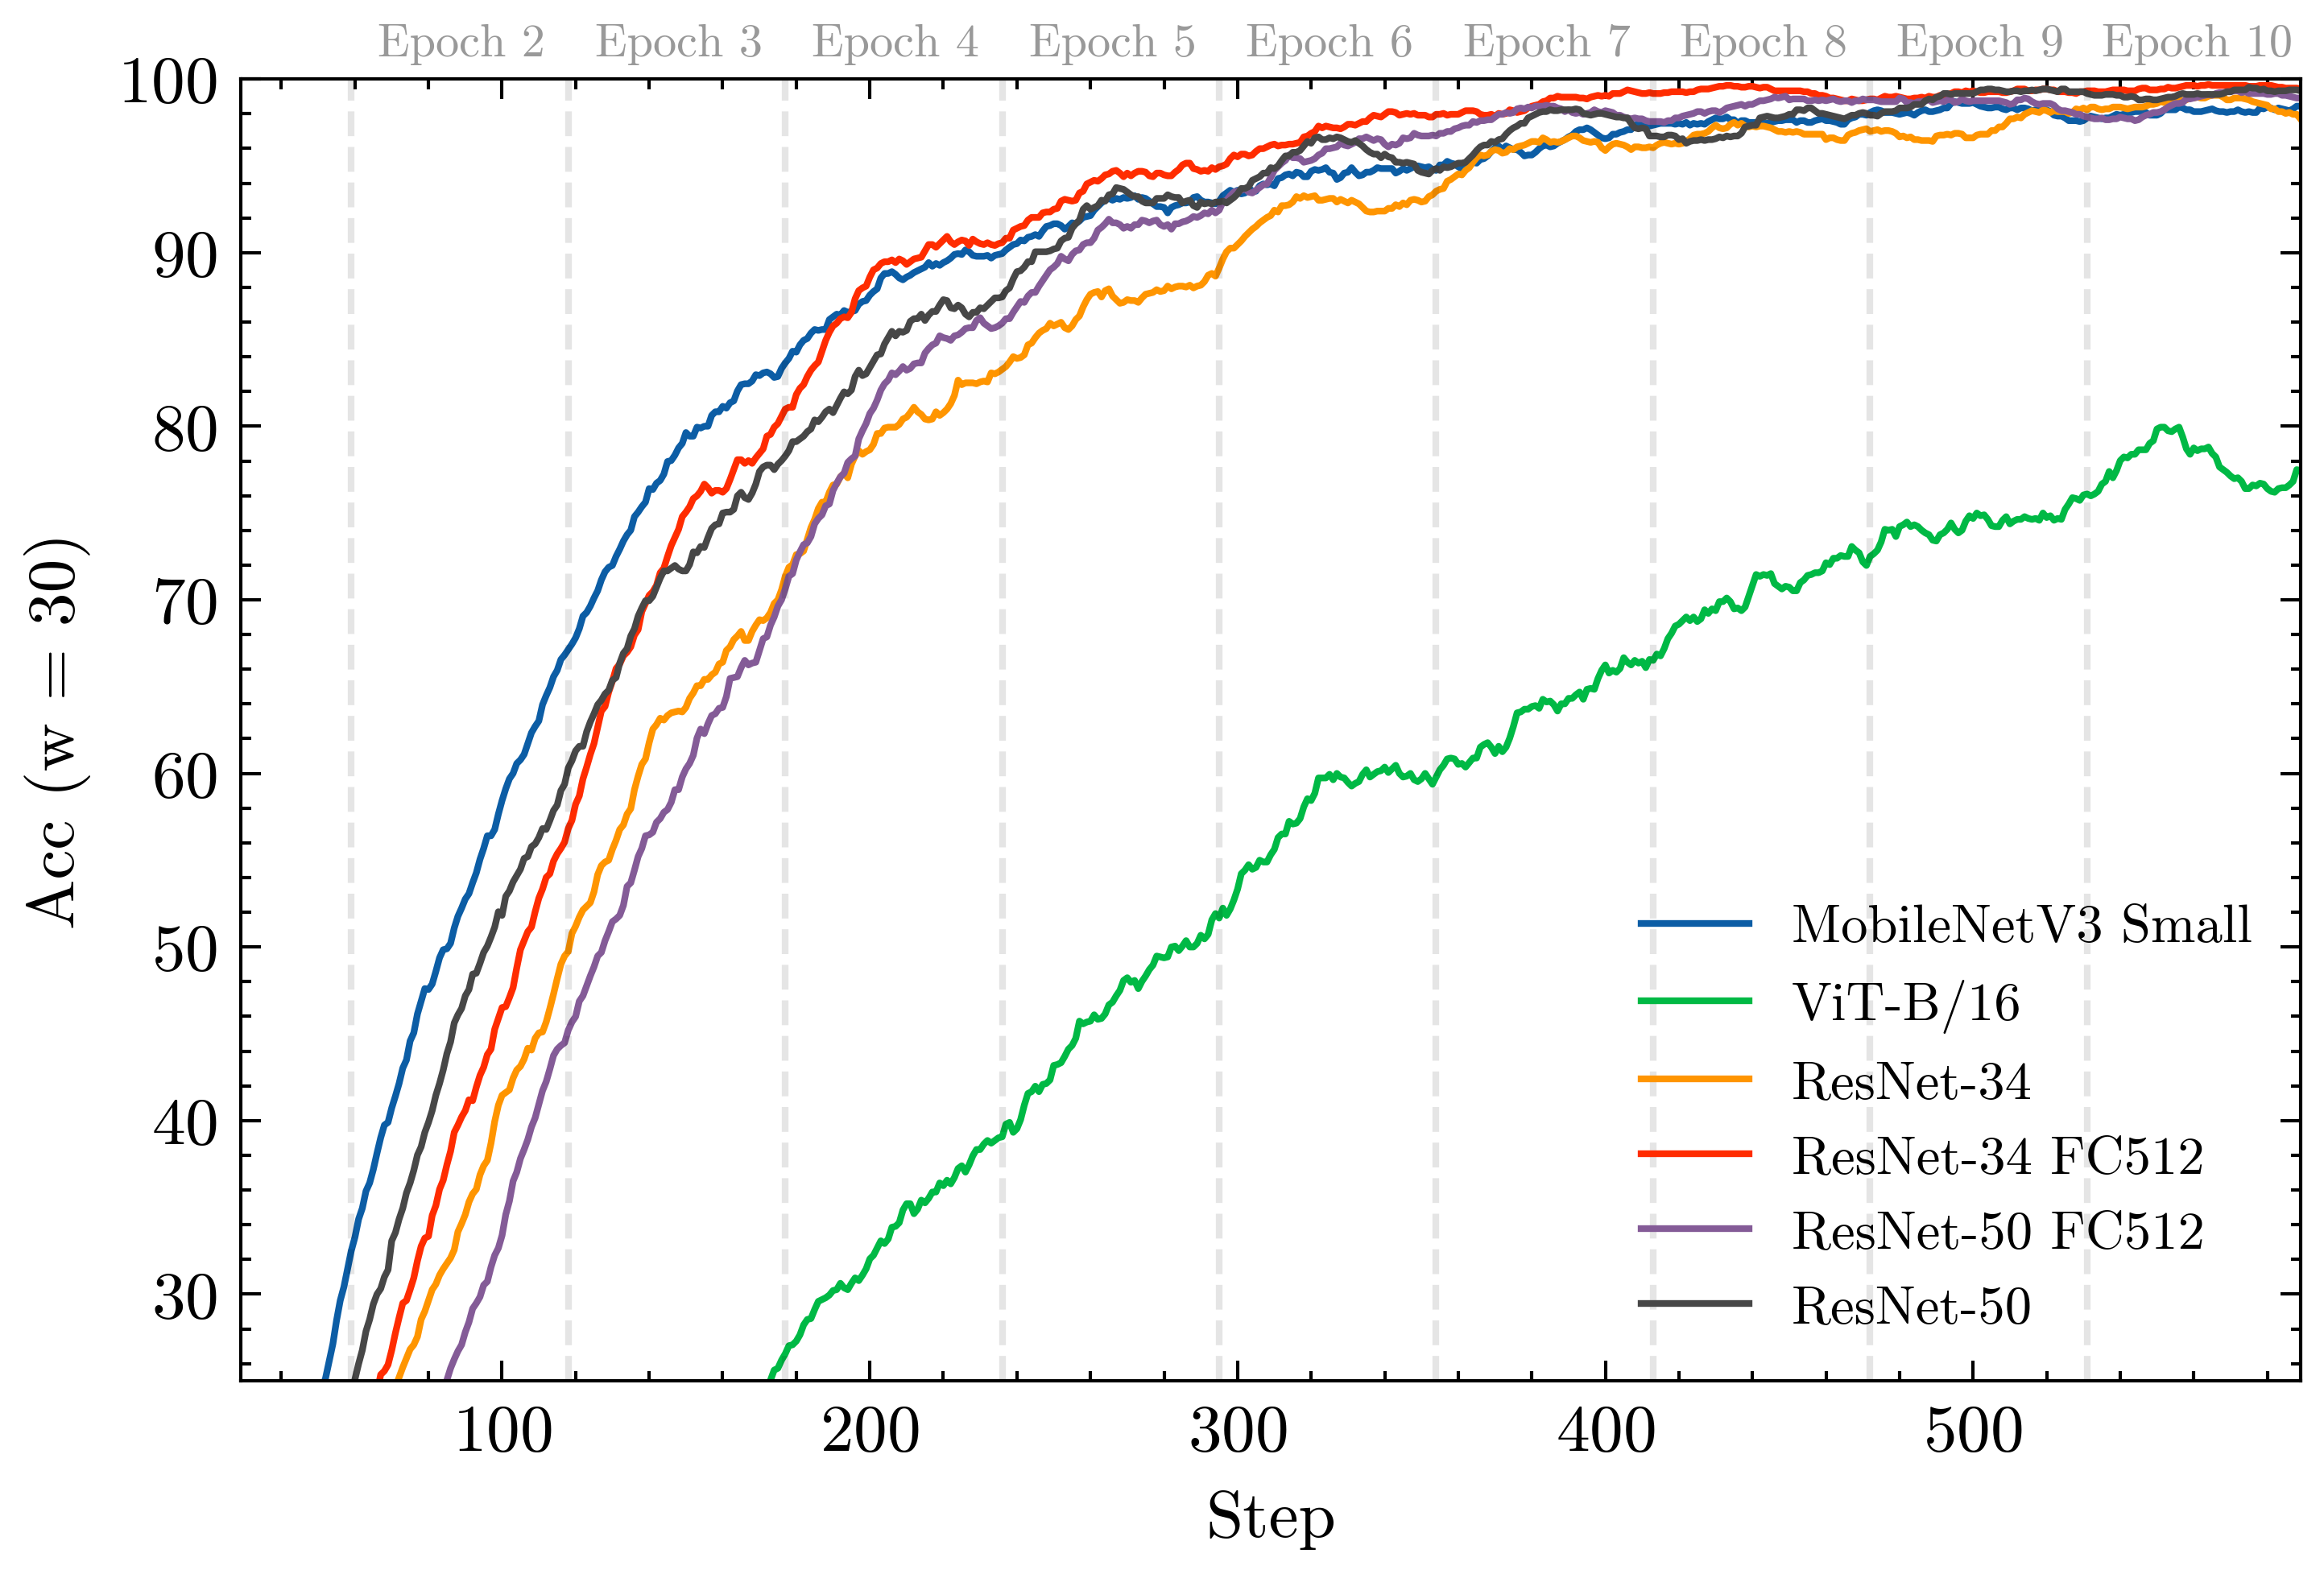

In [103]:
out, labels = read_logs('logs/section1')
print(labels)
# ['mobilenet_v3_small-veri', 'vit_b_16-veri', 'resnet34-veri', 'resnet34_fc512-veri', 'resnet50_fc512-veri', 'resnet50-veri']
labels = ['MobileNetV3 Small', 'ViT-B/16', 'ResNet-34', 'ResNet-34 FC512', 'ResNet-50 FC512', 'ResNet-50']
myplots(out,labels, window=30, ylim = [25, 100], name='section1')

['resnet50-normal-veri', 'resnet50-crop-veri', 'resnet50-erase-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']


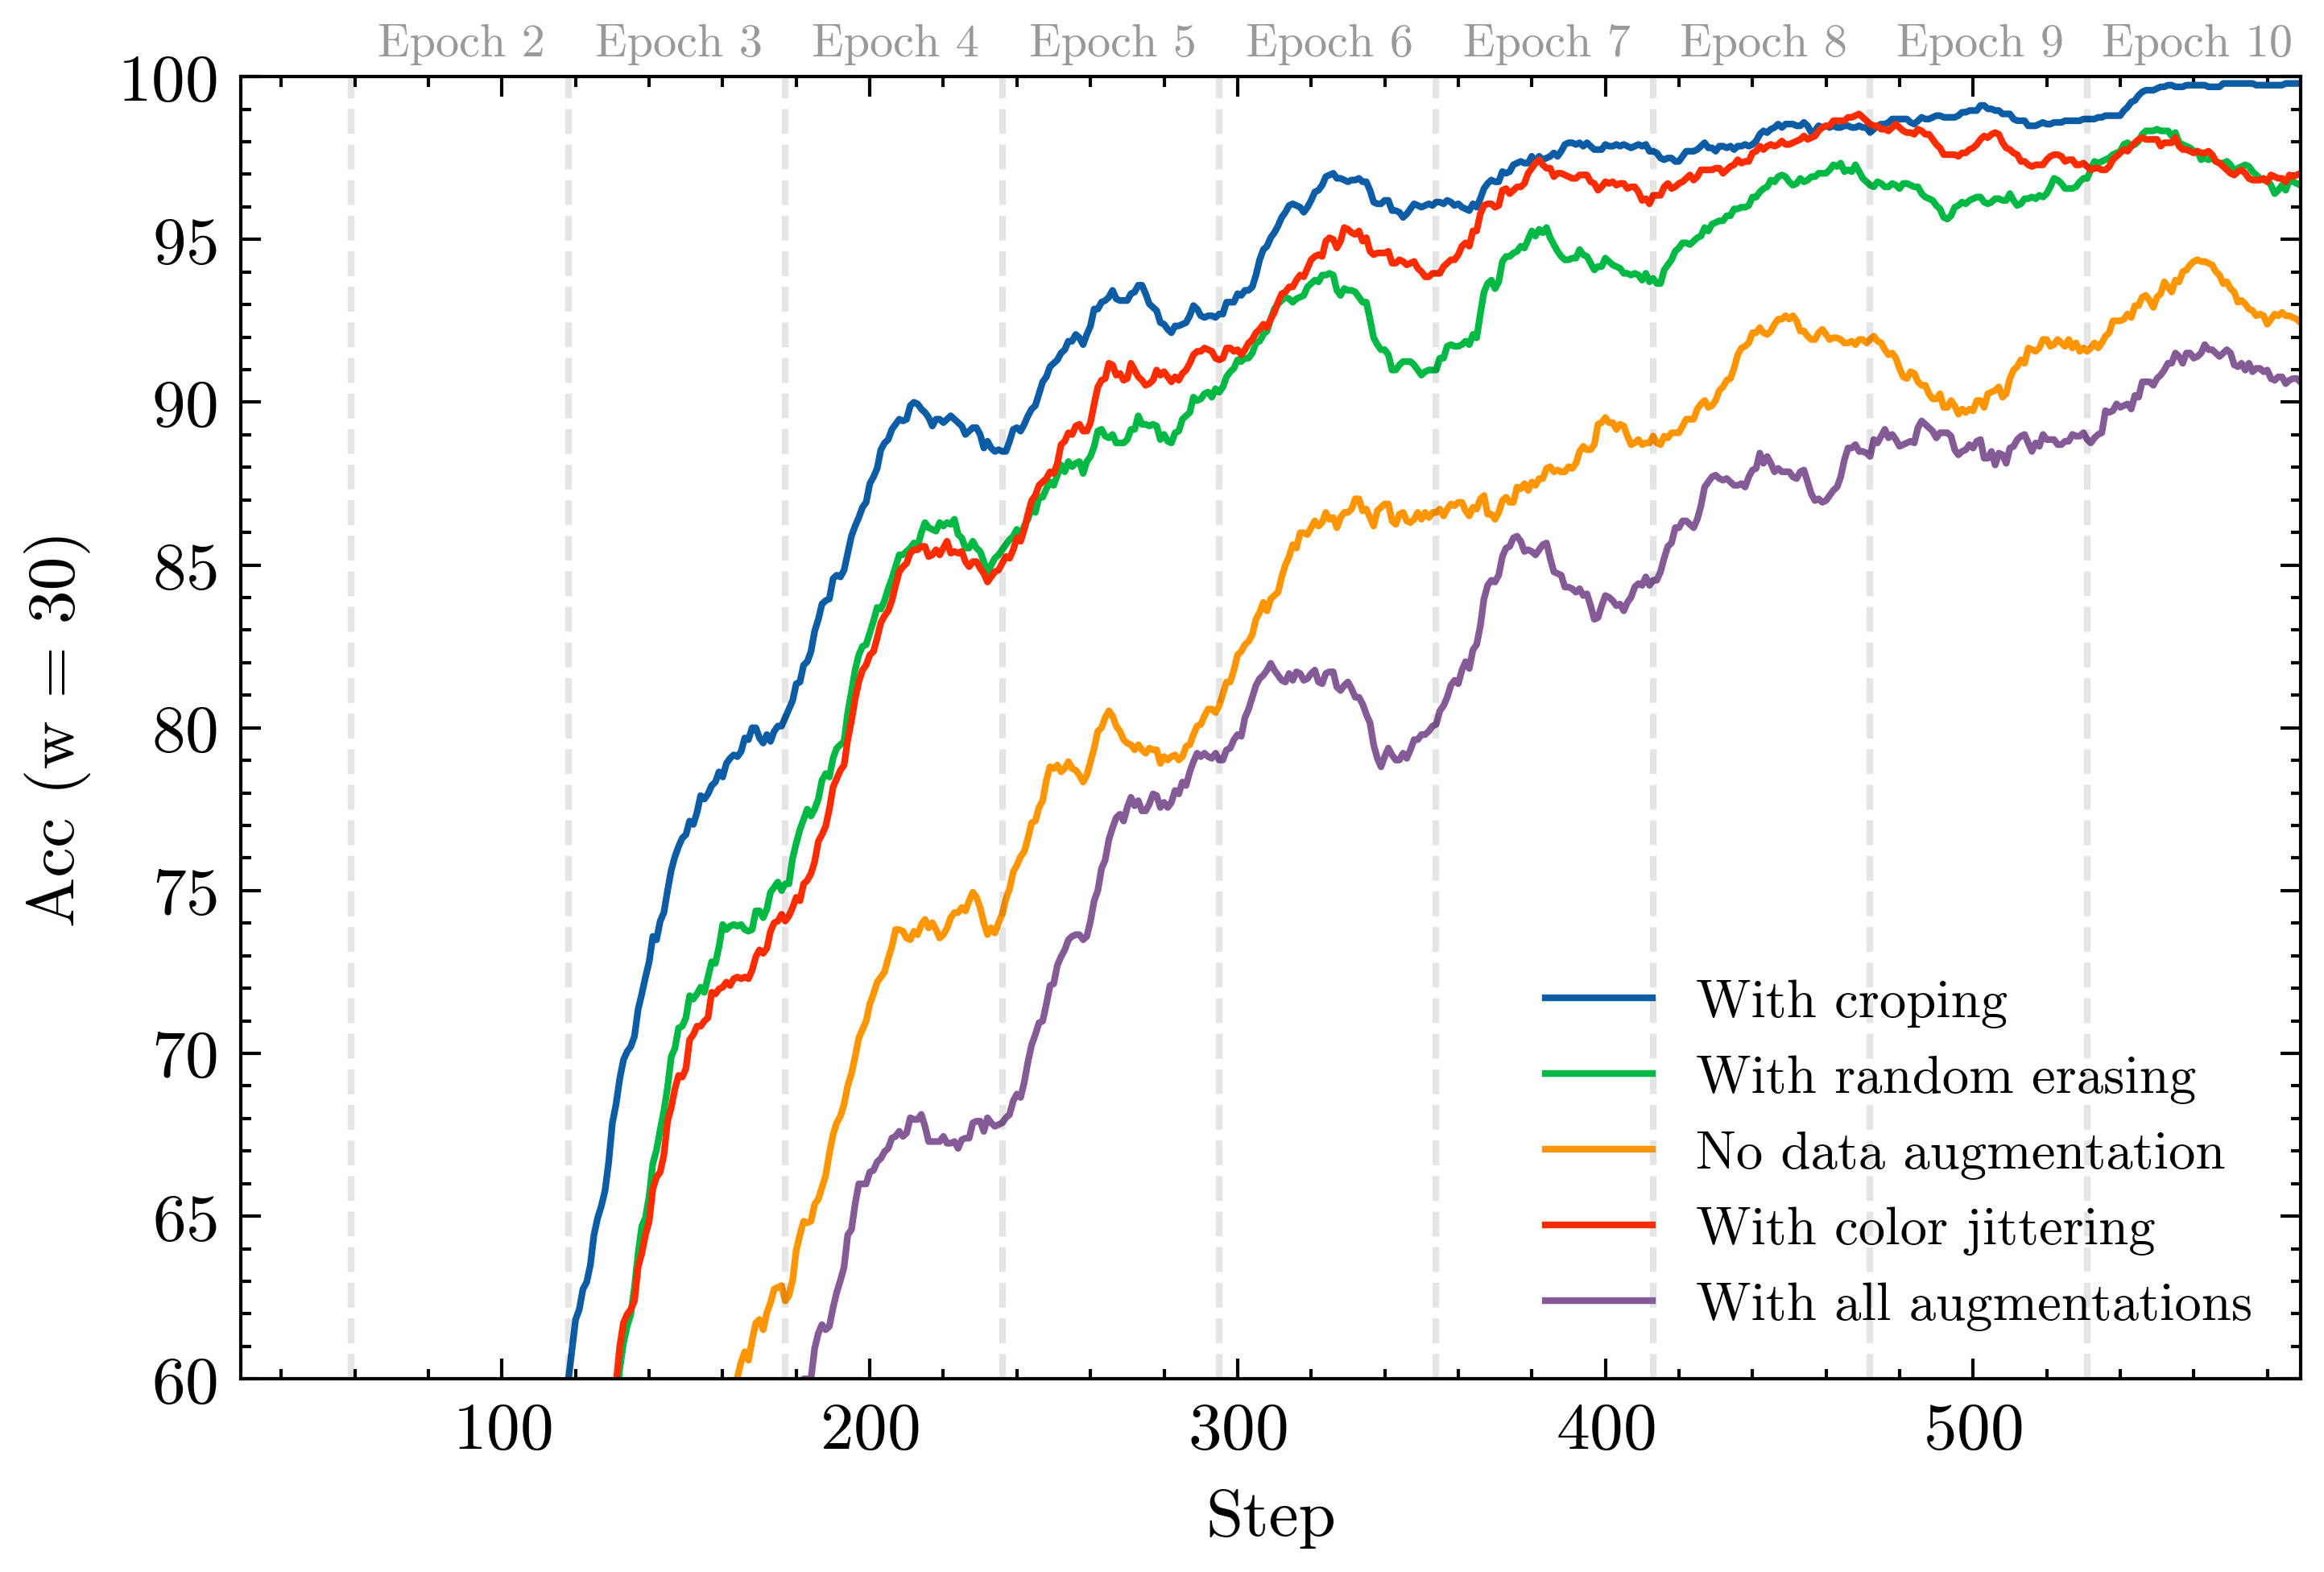

In [104]:
out, labels = read_logs('logs/section2')
print(labels)
# 'resnet50-crop-veri', 'resnet50-erase-veri', 'resnet50-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']
labels = ['With croping', 'With random erasing', 'No data augmentation', 'With color jittering', 'With all augmentations']
myplots(out,labels, window=30, ylim = [60, 100], name='section2', wdelta=1)

['resnet50-normal-veri', 'resnet50-crop-veri', 'resnet50-erase-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']


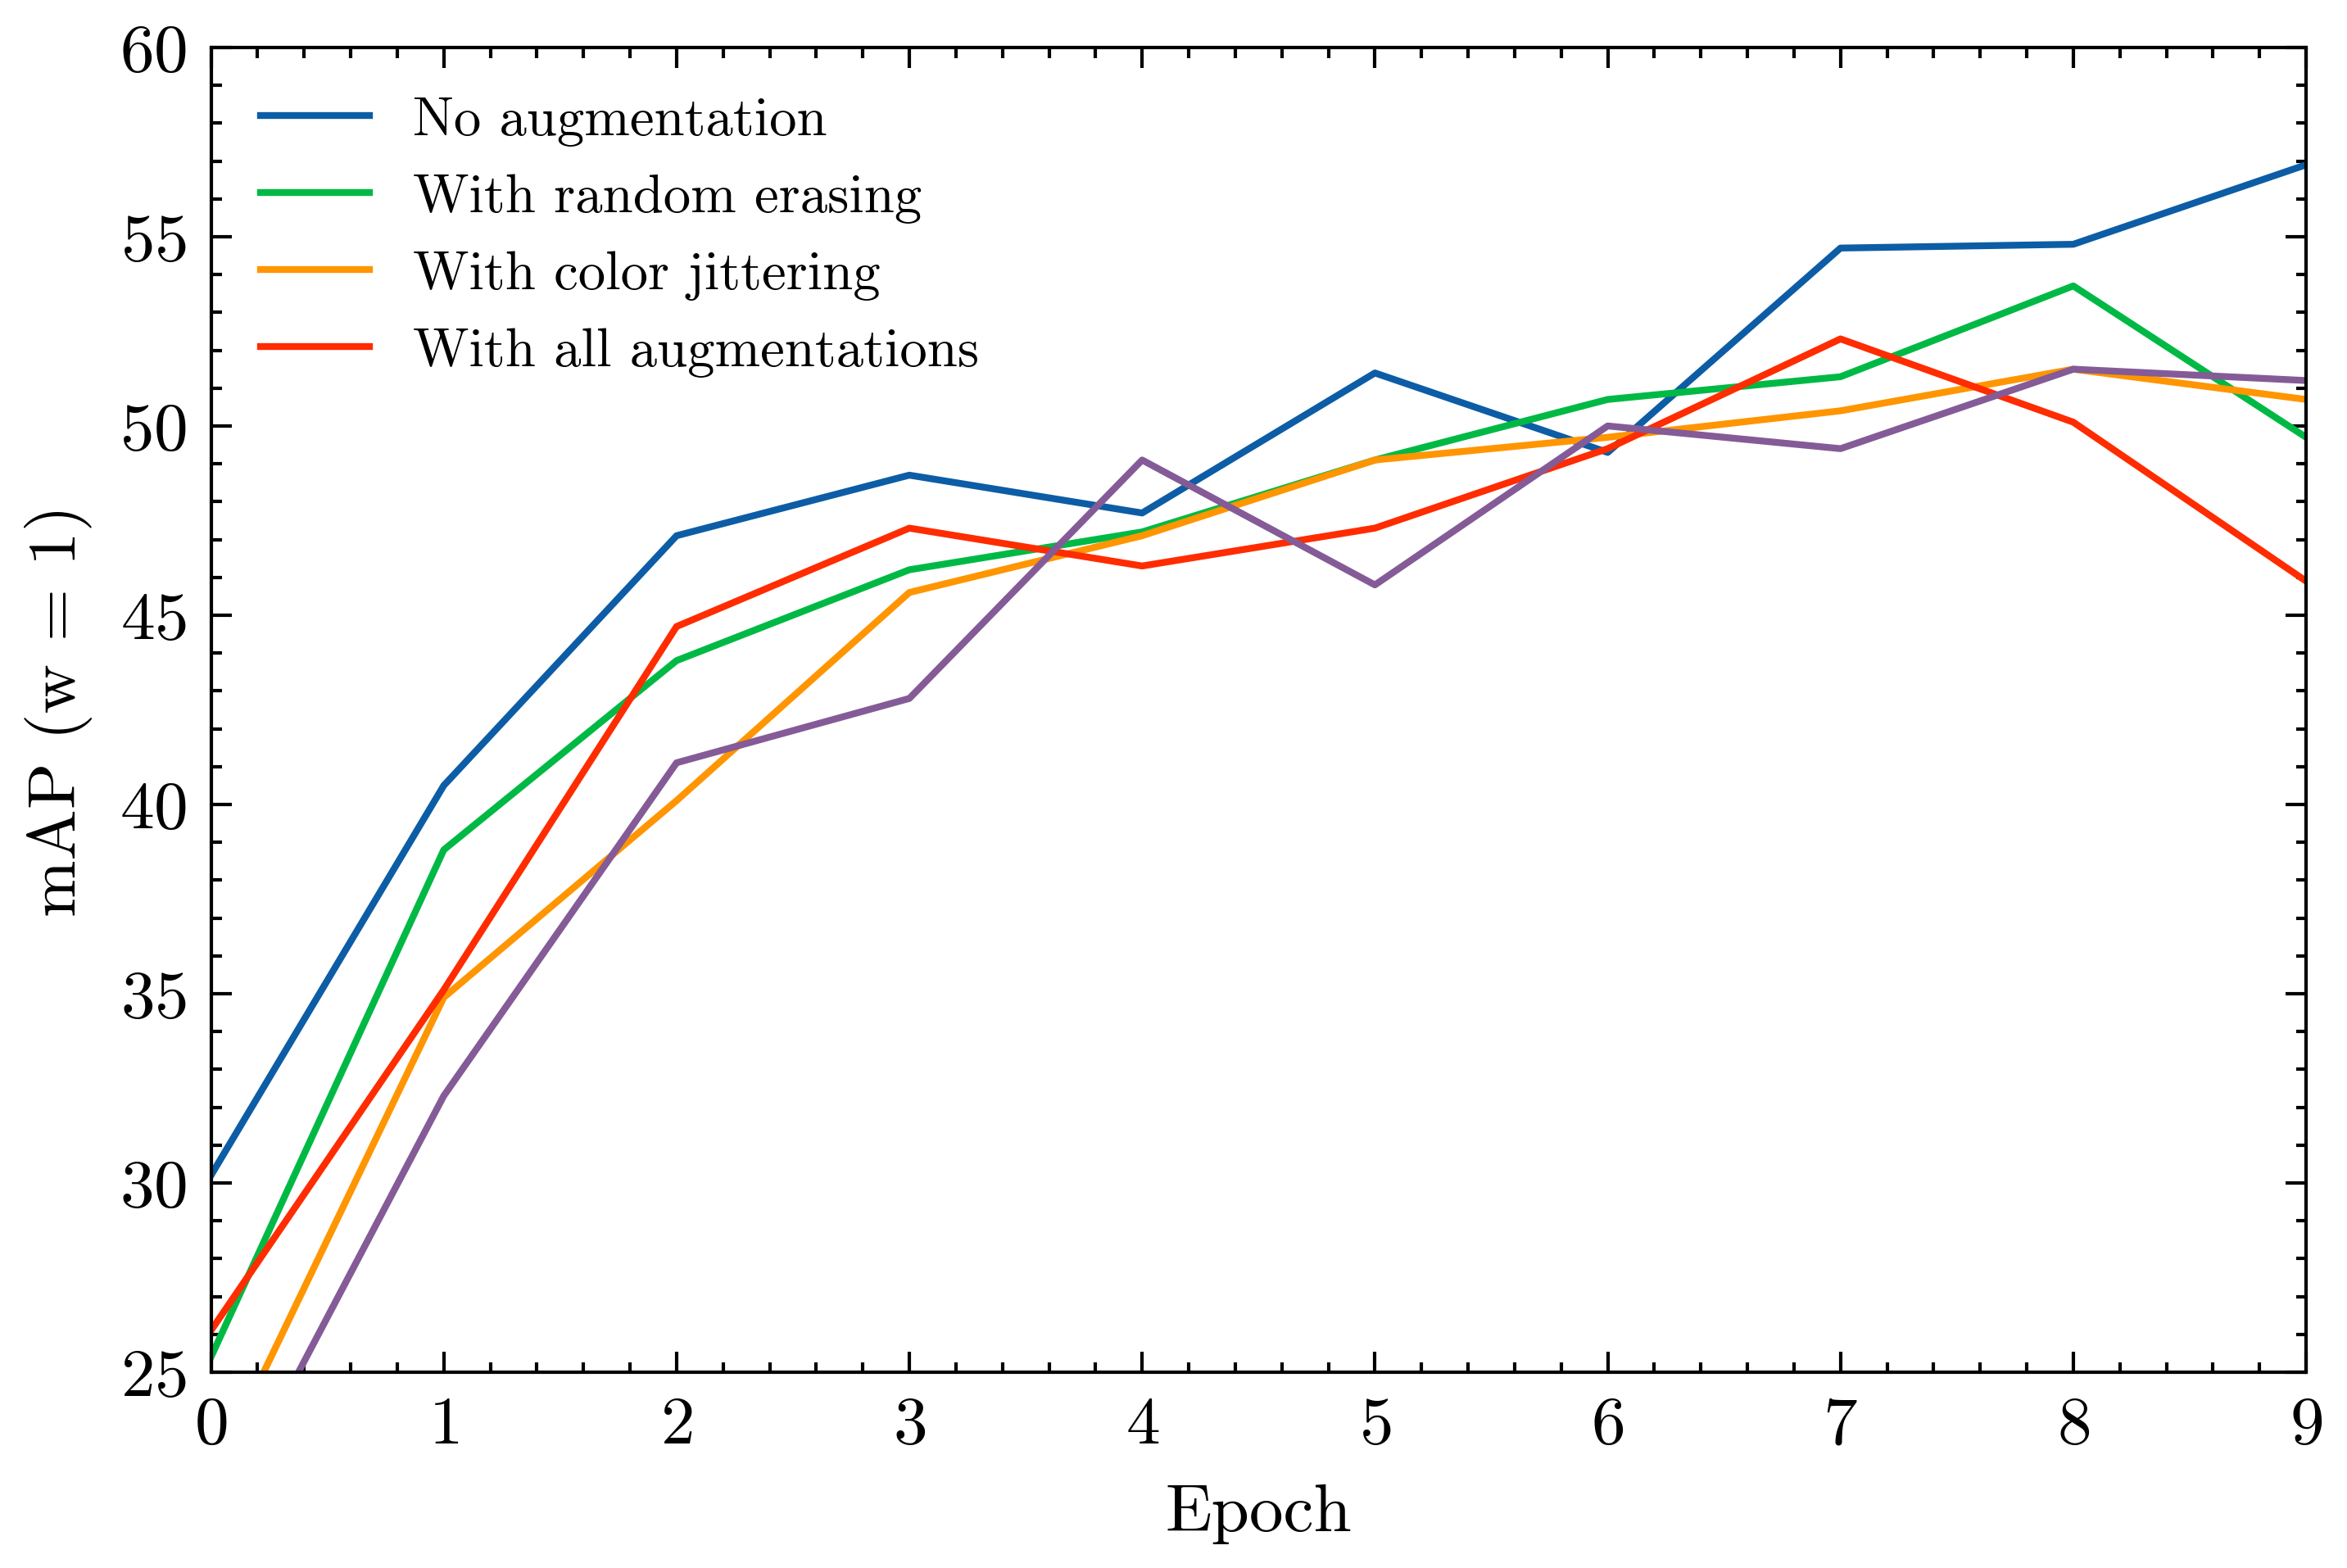

In [105]:
out, labels = read_logs('logs/section2', type='test', metric='mAP')
print(labels)
# ['resnet50-erase-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']
labels = ['No augmentation', 'With random erasing', 'With color jittering', 'With all augmentations']
myplots(out,labels, ylim = [25, 60], name='section2-test', type='test', ylabel='mAP', xlabel='Epoch')

['resnet50-normal-veri', 'resnet50-crop-veri', 'resnet50-erase-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']


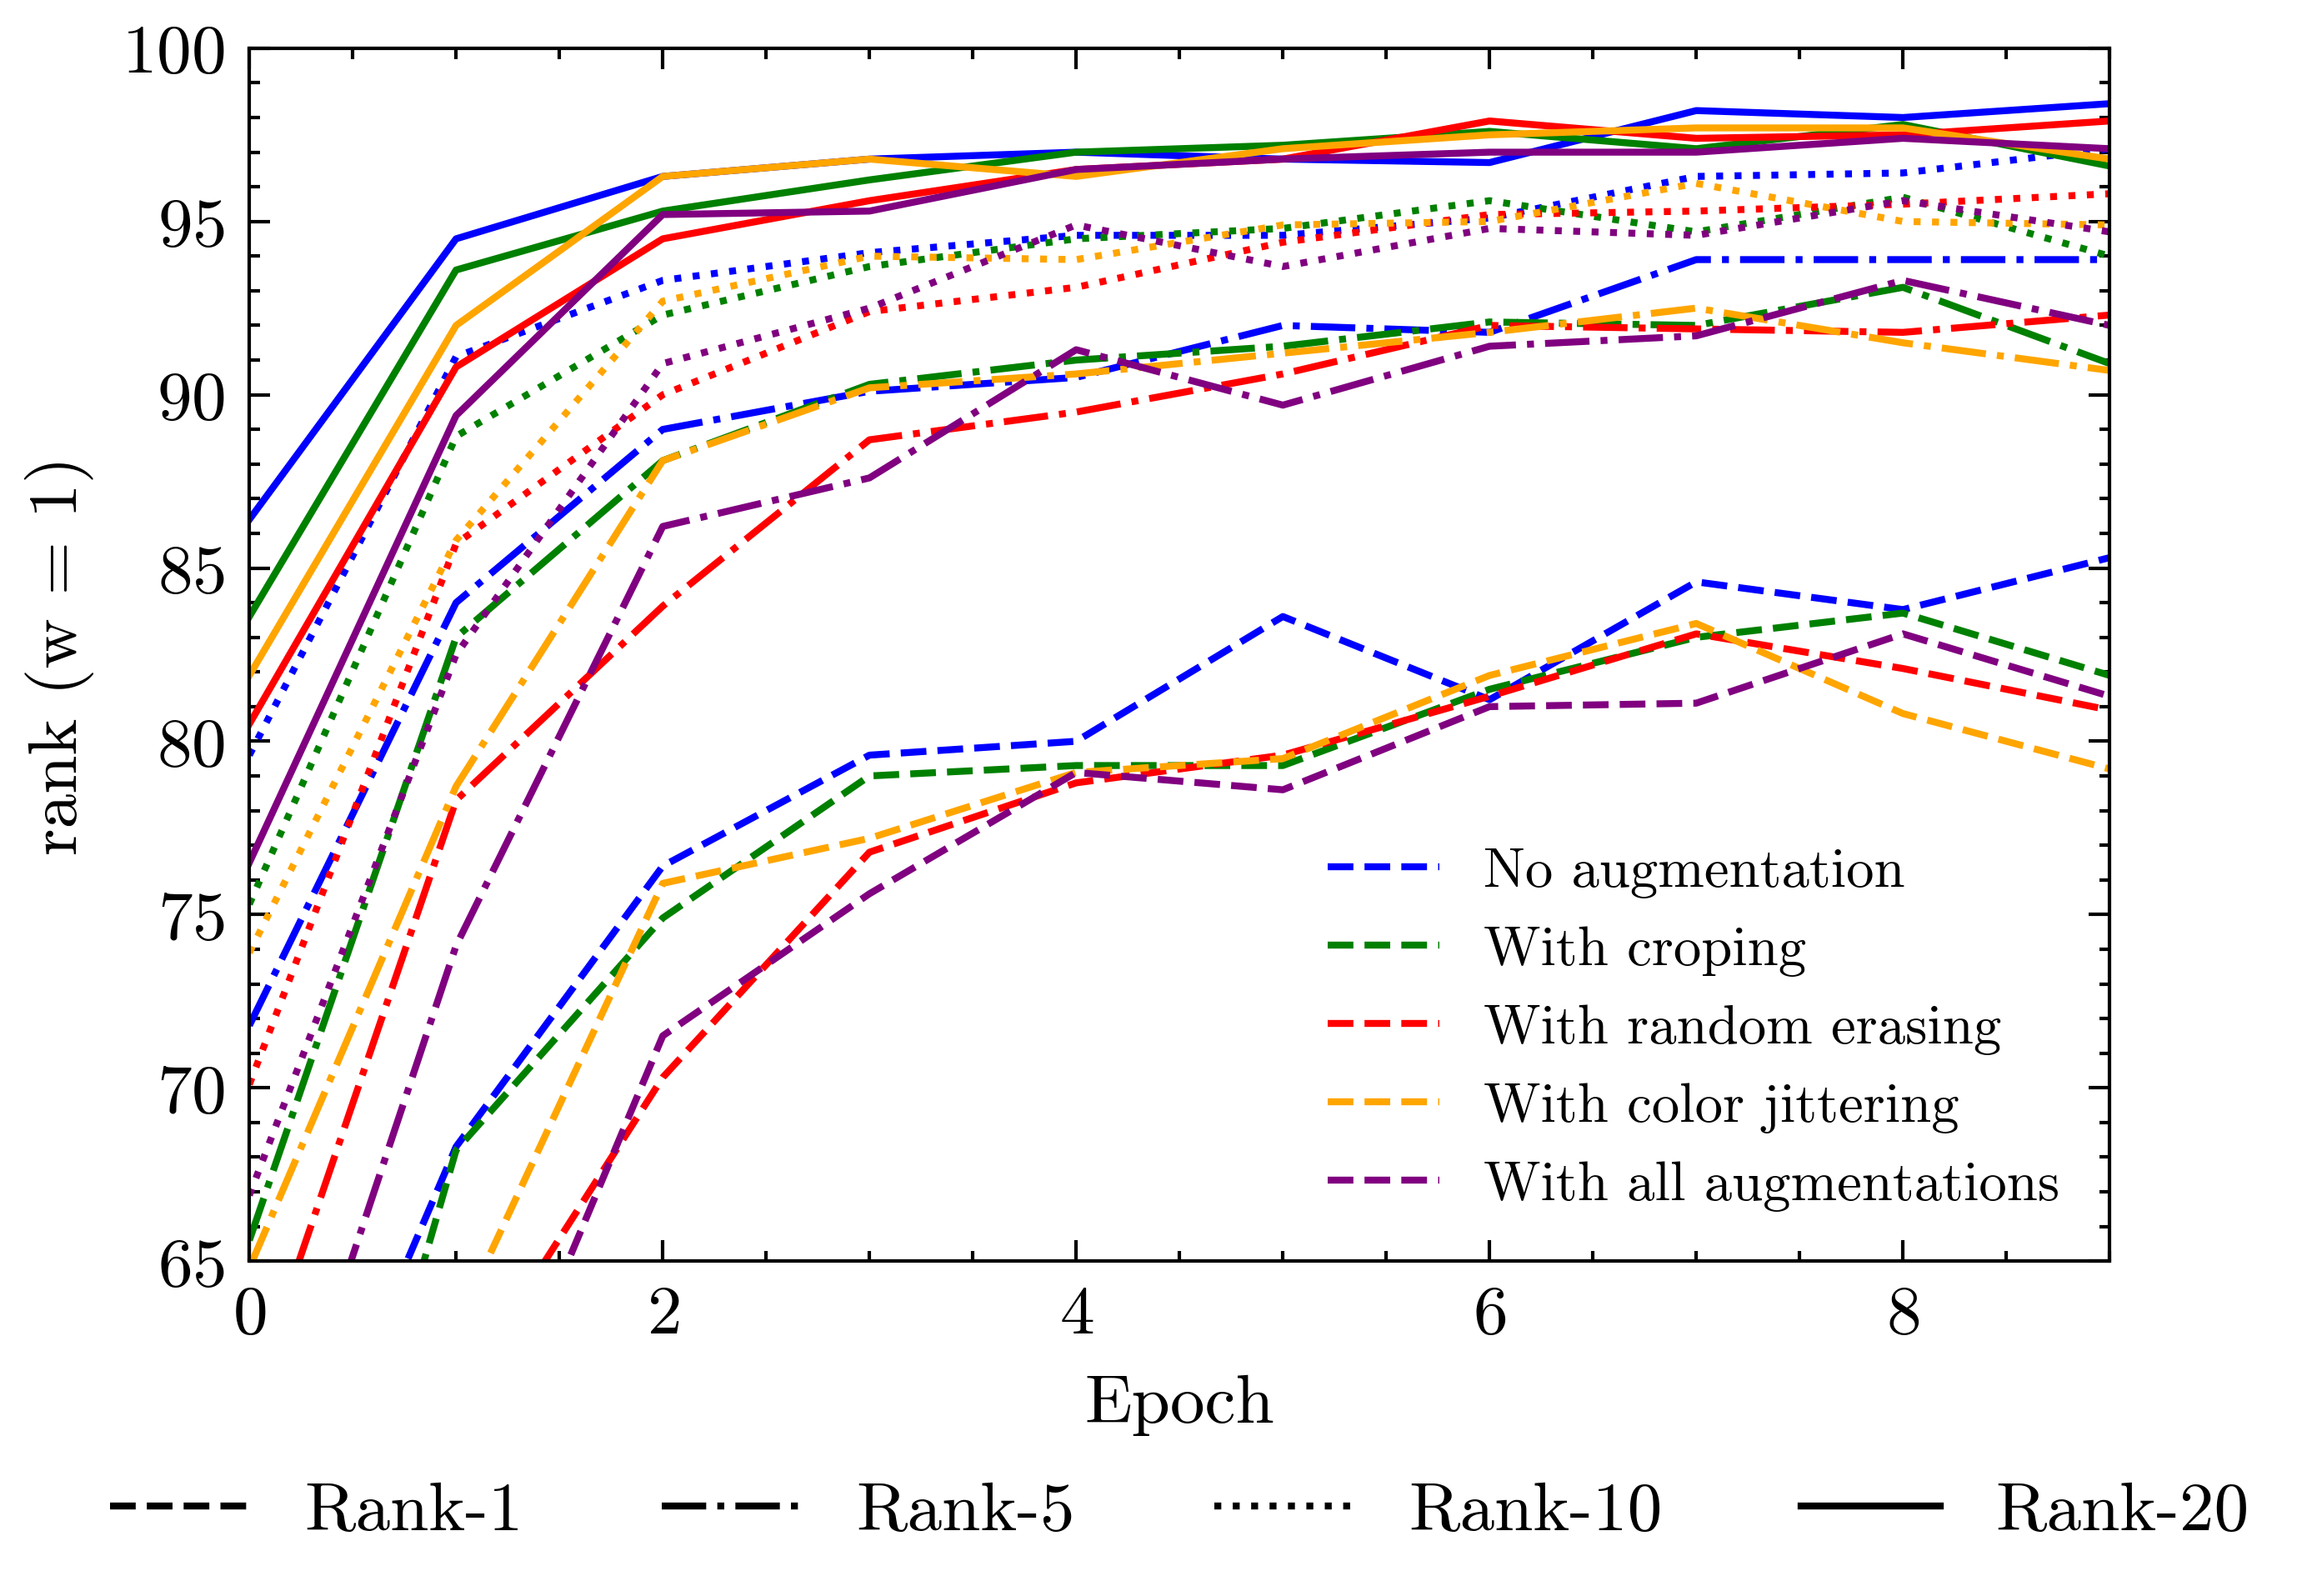

In [106]:
out, labels = read_logs('logs/section2', type='test', metric='rank')
print(labels)
# ['resnet50-erase-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']
labels = ['No augmentation', 'With croping', 'With random erasing', 'With color jittering', 'With all augmentations']
myplots(out,labels, ylim = [65, 100], name='section2-test-ranks', type='test', ylabel='rank', xlabel='Epoch', size=(4.8, 3.5))

['resnet50-normal-veri', 'resnet50-crop-veri', 'resnet50-erase-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']


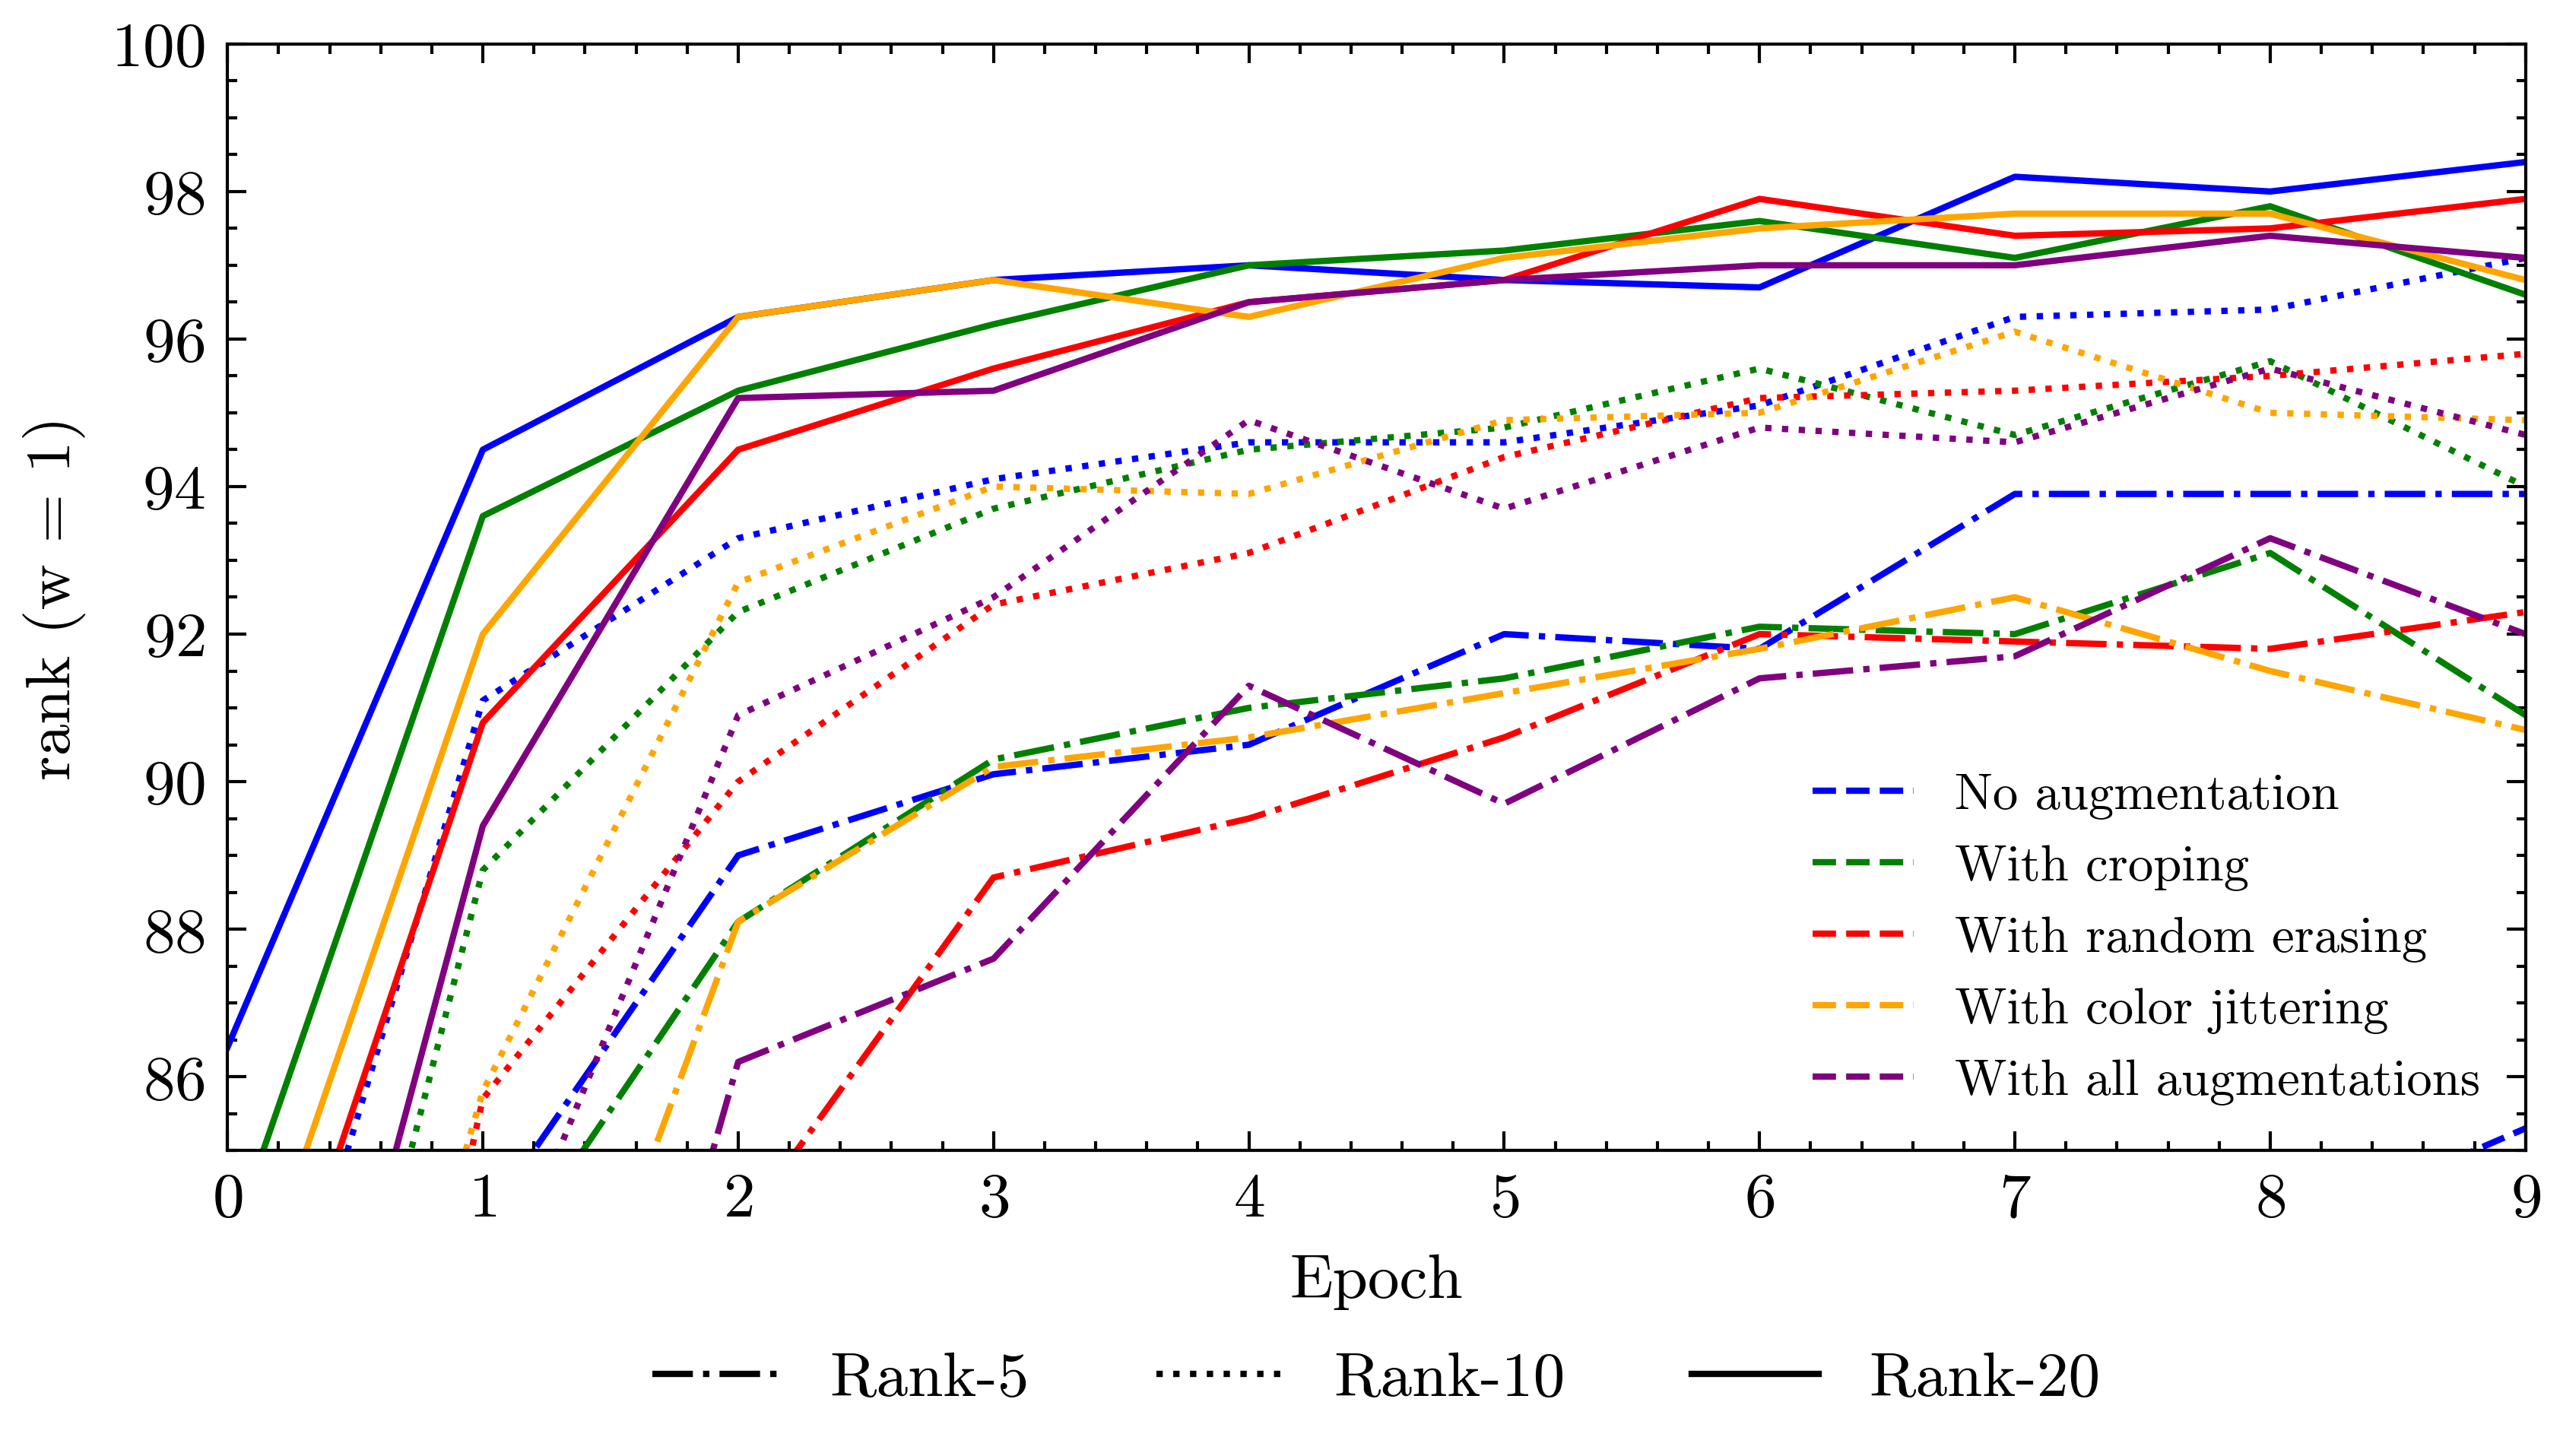

In [107]:
out, labels = read_logs('logs/section2', type='test', metric='rank')
print(labels)
# ['resnet50-erase-veri', 'resnet50-color-veri', 'resnet50-all-augmentations-veri']
labels = ['No augmentation', 'With croping', 'With random erasing', 'With color jittering', 'With all augmentations']
myplots(out,labels, ylim = [85, 100], name='section2-test-ranks-zoom', type='test', ylabel='rank', xlabel='Epoch', size=(6.5, 3.5), remove_one=True)